# Anomaly Detection

Table of Contents

- 1. Anomaly
- 2. Statistical Anomaly Detection
- 3. Deep Learning-based Anomaly Detection
- 4. Anomaly Detection with TensorFlow

### 1. Anomaly

- Anomalies and outliers are essentially the same thing
    - Objects that are different from most other objects
    - Something that deviates from what is standard, or expected (one classification)

#### Causes of Anomalies

- Data from different class of object or underlying mechanism
    - disease vs. non-disease
    - fraud vs. not fraud
- Data measurement and collection errors
- Natural variation
    -tails on a Gaussian distribution

Anomaly Detection

- Finding outliers

![out](./figure/outlier1.png)

#### Applications of Anomaly Detection

- Security & Surveillance


![out](./figure/outlier2.png)

- Biomedical Applications


![out](./figure/outlier3.png)

- Industrial Damage Detection


![out](./figure/outlier4.png)

- Machinery Defects Diagnostics
    - Diagnosis of machinery conditions
    - Early alarm of malfunctioning

Difficulties with Anomaly Detection

- Scarcity of Anomalies
    - It is not easy to get anomaly data, because anomaly rarely happens
    - Overfitting issue occurs when there is only small number of data
- Diverse Types of Anomalies
    - There are so many causes of anomalies
    - At the training stage of neural network, we cannot have all possible anomalies as input data

Use of Data Labels in Anomaly Detection

    -Supervised Anomaly Detection
        - Labels available for both normal data and anomalies
        - Similar to classification with high class imbalance
    -Semi-supervised Anomaly Detection
        -Labels available only for normal data
    -Unsupervised Anomaly Detection
        - No labels assumed
        - Based on the assumption that anomalies are very rare compared to normal data


Output of Anomaly Detection

- Label
  - Each test instance is given a normal or anomaly label
  - Same as the typical output of classification-based approaches

- Score
    - Each test instance is assigned an anomaly score
    - Allows outputs to be ranked in the order of anomaly scores
    - Requires an additional threshold parameter


Variants of Anomaly Detection Problem

- Given a dataset  D
 , find all the data points  x∈D
  with anomaly scores greater than some threshold  t
 
- Given a dataset  D
 , find all the data points  x∈D
  having the top-n largest anomaly scores
- Given a dataset  D
 , containing mostly normal data points, and a test point  x
 , compute the anomaly score of  x
  with respect to  D

## 2. Deep Learning-based Anomaly Detection¶



- Train autoencoders only with normal data
    - Trained autoencoders will only capture features of normal data
    
    
- Test with (normal + anomaly) data

![ano](./figure/anomaly2.png)

### Setup

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

#### Load the data

- We will use Numenta Anomaly Benchmark(NAB) dataset
- It provides artifical timeseries data containing labeled anomalous periods of behavior.

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

#### Quick look at the data

In [102]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


#### Visualize the data

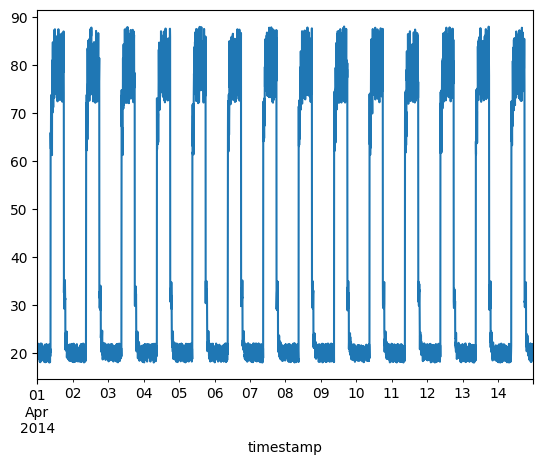

In [103]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

#### Timeseries data with anomalies


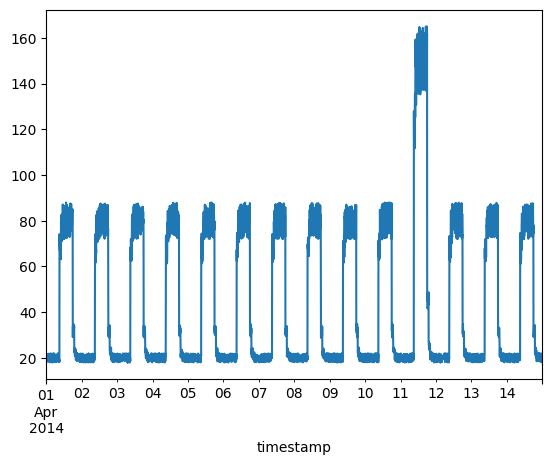

In [104]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

#### Preparing data

-   24 * 60 / 5 = **288 timesteps per day**
-   288 * 14 = **4032 data points** in total

In [105]:
print(df_small_noise.shape, df_daily_jumpsup.shape)

(4032, 1) (4032, 1)


In [106]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


#### Create sequence
- Create sequences combining TIME_STEPS contiguous data values from the training data

In [107]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


#### Build a model

- The model will take input of shape `(batch_size, sequence_length, num_features)` 
- Return output of the same shape.
- Our model  `sequence_length` is 288 and `num_features` is 1.

In [108]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_87 (Conv1D)          (None, 144, 32)           256       
                                                                 
 dropout_10 (Dropout)        (None, 144, 32)           0         
                                                                 
 conv1d_88 (Conv1D)          (None, 72, 16)            3600      
                                                                 
 conv1d_transpose_11 (Conv1D  (None, 144, 16)          1808      
 Transpose)                                                      
                                                                 
 dropout_11 (Dropout)        (None, 144, 16)           0         
                                                                 
 conv1d_transpose_12 (Conv1D  (None, 288, 32)          3616      
 Transpose)                                          

#### Train the model

- Note that we are using x_train as both the input and the target
- because of this is reconstruction model

In [109]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 5s 108ms/step - loss: 0.6488 - val_loss: 0.1208
Epoch 2/50
27/27 [==============================] - 2s 84ms/step - loss: 0.0917 - val_loss: 0.0424
Epoch 3/50
27/27 [==============================] - 2s 83ms/step - loss: 0.0568 - val_loss: 0.0359
Epoch 4/50
27/27 [==============================] - 2s 83ms/step - loss: 0.0474 - val_loss: 0.0312
Epoch 5/50
27/27 [==============================] - 3s 105ms/step - loss: 0.0405 - val_loss: 0.0275
Epoch 6/50
27/27 [==============================] - 3s 113ms/step - loss: 0.0354 - val_loss: 0.0257
Epoch 7/50
27/27 [==============================] - 2s 82ms/step - loss: 0.0316 - val_loss: 0.0247
Epoch 8/50
27/27 [==============================] - 2s 82ms/step - loss: 0.0286 - val_loss: 0.0242
Epoch 9/50
27/27 [==============================] - 3s 98ms/step - loss: 0.0264 - val_loss: 0.0247
Epoch 10/50
27/27 [==============================] - 6s 207ms/step - loss: 0.0247 - val_loss: 0.0248
Epoch

#### plot training and validation loss 

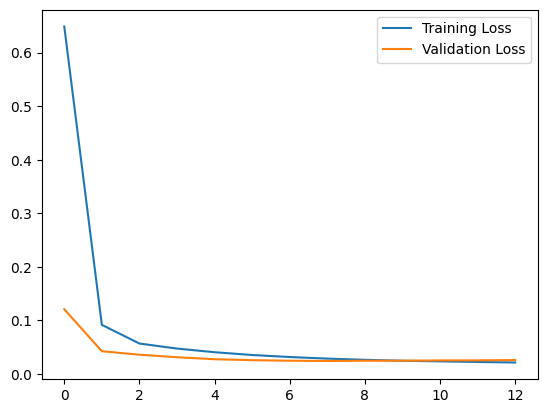

In [120]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct
the input data.


1.   Find MAE loss on training samples.
2.   Find max MAE loss value. 
   
         - This is the worst our model has performed trying to reconstruct a sample. 
         - We will make this the `threshold` for anomalydetection.
  
3.   If the reconstruction loss for a sample is greater than this `threshold`
value then we can infer that the model is seeing a pattern that it isn't
familiar with. 
1. We will label this sample as an `anomaly`.


118/118 [==============================] - 1s 9ms/step


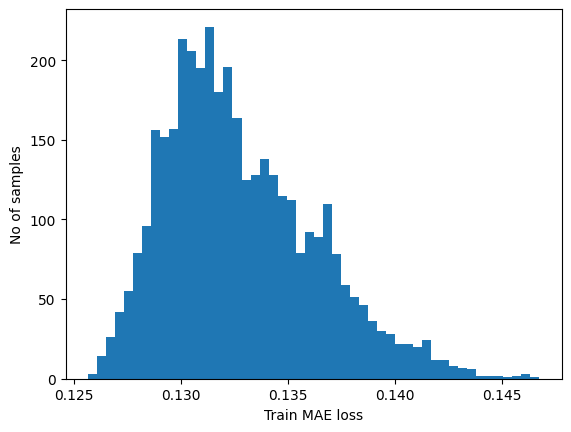

Reconstruction error threshold:  0.14674234495008764


In [121]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

# plt.hist(, bins= #)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

Compare reconstruction
- 288 timesteps from day

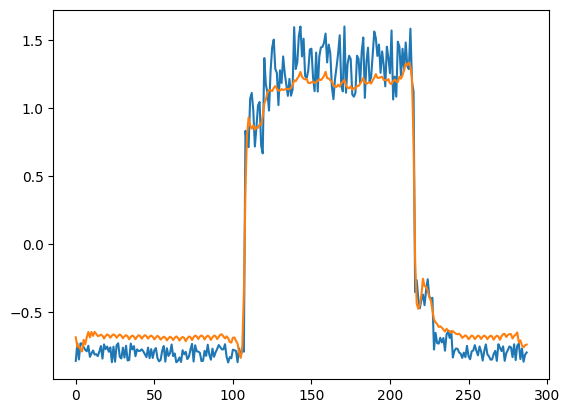

In [122]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

#### Prepare test data

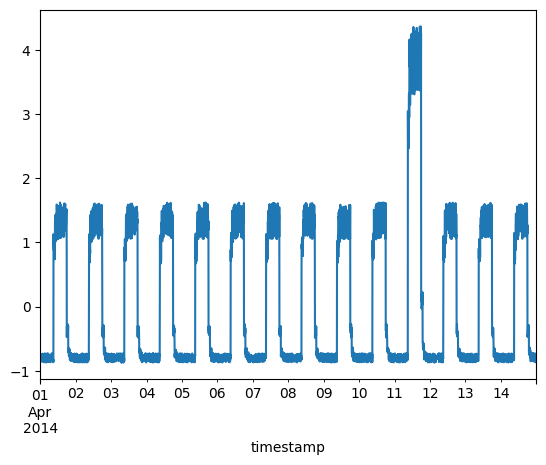

In [123]:
# Normalization to test data
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()


In [124]:
# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)


Test input shape:  (3745, 288, 1)


In [125]:

# Get test MAE loss.
x_test_pred = model.predict(x_test)
print(x_test_pred.shape)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
print(test_mae_loss.shape)
test_mae_loss = test_mae_loss.reshape((-1))
print(test_mae_loss.shape)


118/118 [==============================] - 1s 9ms/step
(3745, 288, 1)
(3745, 1)
(3745,)


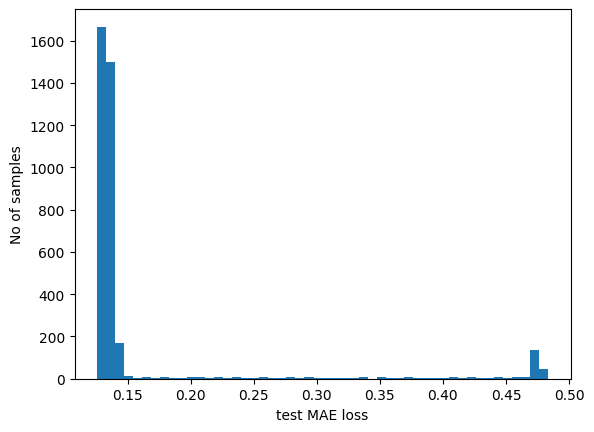

In [126]:

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()


In [127]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  407
Indices of anomaly samples:  (array([ 789,  790,  795, 1650, 1652, 1653, 1654, 1658, 1659, 2522, 2523,
       2697, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710,
       2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721,
       2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732,
       2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743,
       2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754,
       2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765,
       2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776,
       2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787,
       2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798,
       2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809,
       2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820,
       2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2

## Plot anomalies

-  With this, we will find the corresponding `timestamps` from the original test data. 

Our `x_train` will look like this:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

All except the initial and the final time_steps-1 data values, will appear in `time_steps` number of samples. 
So, if we know that the samples[(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point
5 is an anomaly.

In [128]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

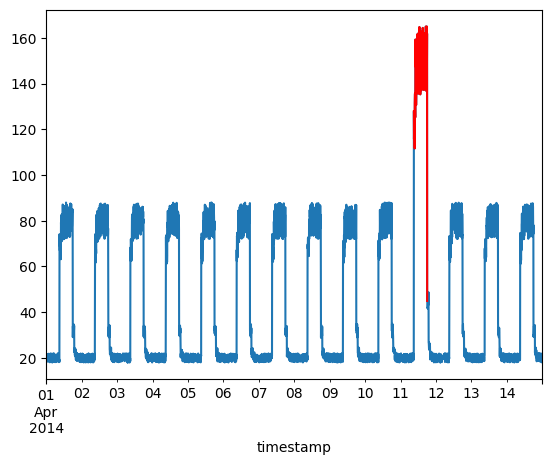

In [129]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

# ECG Anomaly

kaggle ecg anomaly detection

https://sanghyu.tistory.com/24

output_length = (input_length - kernel_size + 2 * padding) / stride + 1

Valid Padding: In this case, padding = 0, and the formula simplifies to:

output_length = (input_length - kernel_size) / stride + 1

Same Padding: In this case, padding = kernel_size // 2, and the formula becomes:  

output_length = (input_length - kernel_size + kernel_size) / stride + 1 = input_length / stride + 1

Note that in most cases, the stride is set to 1, so the output length remains the same as the input length with 'same' padding. With 'valid' padding, the output length will be reduced.


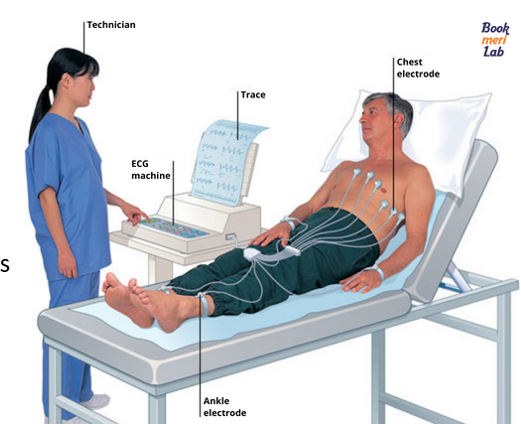[링크 텍스트](https://)

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model

In [3]:
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [4]:
#Now we will separate the data and labels so that it will be easy for us
data = df.iloc[:,:-1].values
labels = df.iloc[:,-1].values
labels

array([1., 1., 1., ..., 0., 0., 0.])

In [6]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.2, random_state = 21)

Lets normalize the data to the range [0-1]

We will use the simple formula :-

![norm](./figure/norm.png)

In [ ]:
import tensorflow as tf

# Create a 2x3 matrix (tensor)
a = tf.constant([[1, 2, 3], [4, 5, 6]])

# Find the minimum value along axis 0 (columns)
min_a = tf.reduce_min(a, axis=0)

# Find the minimum value along axis 1 (rows)
min_b = tf.reduce_min(a, axis=1)

# Find the minimum value in the entire tensor
min_c = tf.reduce_min(a)

In [ ]:
# print("Min along axis 0:", )
# print("Min along axis 1:",)
# print("Min in the entire tensor:",)

In [7]:
#Now lets Normalize the data
#First we will calculate the maximum and minimum value from the training set 
min = tf.reduce_min(train_data)
max = tf.reduce_max(train_data)

#Now we will use the formula (data - min)/(max - min)
train_data = (train_data - min)/(max - min)
test_data = (test_data - min)/(max - min)

#I have converted the data into float
train_data = tf.cast(train_data, dtype=tf.float32)
test_data = tf.cast(test_data, dtype=tf.float32)

In [10]:
#The labels are either 0 or 1, so I will convert them into boolean(true or false) 
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

In [85]:
#Now let's separate the data for normal ECG from that of abnormal ones
#Normal ECG data
normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

#Abnormal ECG data
anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

print(normal_train_data)

tf.Tensor(
[[0.57030463 0.46561658 0.29058117 ... 0.48504233 0.4233502  0.47598344]
 [0.48320588 0.28246963 0.16471253 ... 0.567567   0.4677294  0.2692329 ]
 [0.48144642 0.35151404 0.25972766 ... 0.5479421  0.5077544  0.54298663]
 ...
 [0.41039047 0.24164985 0.13120876 ... 0.5277313  0.5654091  0.5023885 ]
 [0.5397748  0.4140786  0.28101394 ... 0.51266515 0.43706053 0.4426865 ]
 [0.29639772 0.15988176 0.18883787 ... 0.53766966 0.545786   0.40826708]], shape=(2359, 140), dtype=float32)


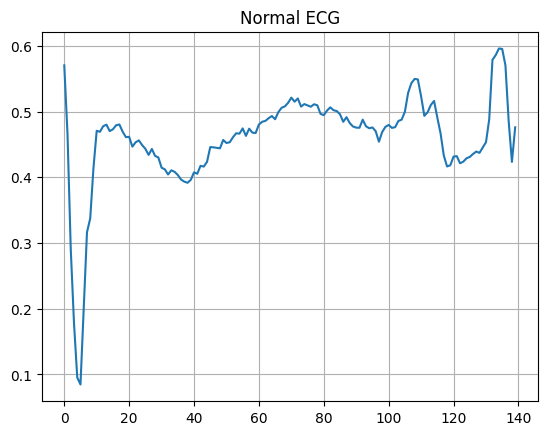

In [86]:
#Lets plot a normal ECG
plt.plot(np.arange(140), normal_train_data[0])
plt.grid()
plt.title('Normal ECG')
plt.show()

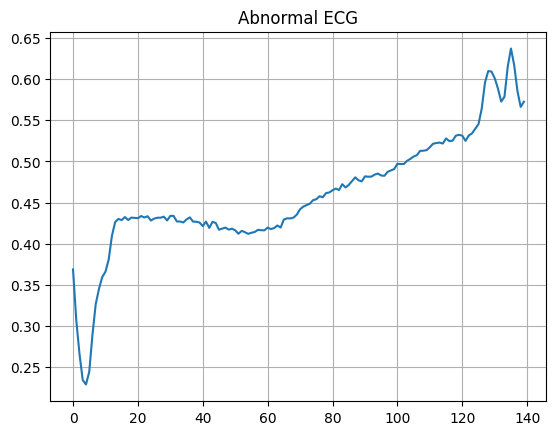

In [87]:
#Lets plot one from abnormal ECG
plt.plot(np.arange(140), anomalous_test_data[0])
plt.grid()
plt.title('Abnormal ECG')
plt.show()

In [89]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      ])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [90]:
#Let's compile and train the model!!
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

In [140]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 0s 35ms/step - loss: 0.0220 - val_loss: 0.0334
Epoch 2/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0215 - val_loss: 0.0332
Epoch 3/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0210 - val_loss: 0.0329
Epoch 4/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0206 - val_loss: 0.0327
Epoch 5/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0202 - val_loss: 0.0326
Epoch 6/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0200 - val_loss: 0.0324
Epoch 7/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0199 - val_loss: 0.0324
Epoch 8/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0197 - val_loss: 0.0323
Epoch 9/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0196 - val_loss: 0.0317
Epoch 10/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0195 - val_loss: 0.0316
Epoch 11/20
5/5 [============

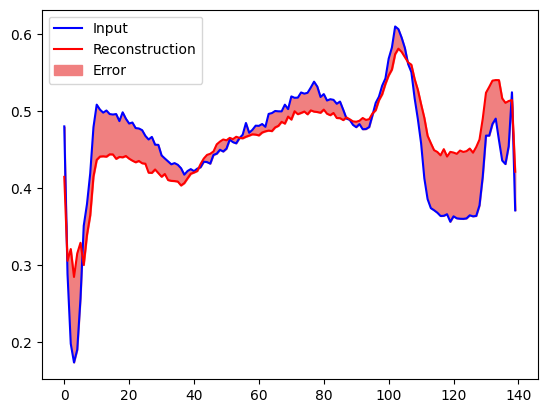

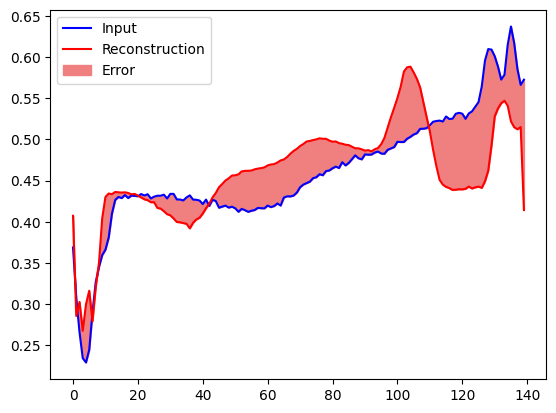

In [94]:
#Now let's define a function in order to plot the original ECG and reconstructed ones and also show the error
def plot(data, n):
  enc_img = autoencoder.encoder(data)
  dec_img = autoencoder.decoder(enc_img)
  #dec_img = tf.squeeze(dec_img, axis=-1)  
  plt.plot(data[n], 'b')
  plt.plot(dec_img[n], 'r')
  plt.fill_between(np.arange(140), data[n], dec_img[n], color = 'lightcoral')
  plt.legend(labels=['Input', 'Reconstruction', 'Error'])
  plt.show()

plot(normal_test_data, 0)
plot(anomalous_test_data, 0)

In [96]:
reconstructed = autoencoder(normal_train_data)
# reconstructed = tf.squeeze(reconstructed, axis=-1)  
train_loss = losses.mae(reconstructed, normal_train_data)
t = np.mean(train_loss) + np.std(train_loss)

def prediction(model, data, threshold):
  rec = model(data)
  #rec = tf.squeeze(rec, axis=-1)  
  loss = losses.mae(rec, data)
  return tf.math.less(loss, threshold)
print(t)

0.033656374


In [97]:

pred = prediction(autoencoder, normal_test_data, t)

print(pred)

tf.Tensor(
[False  True  True False  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  Tr

In [98]:
list(pred).count(True) / pred.shape[0]

0.9053571428571429

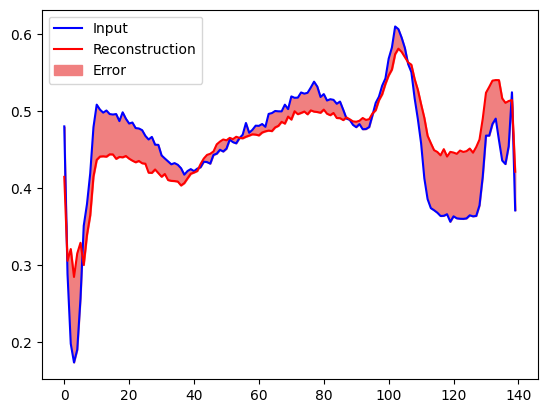

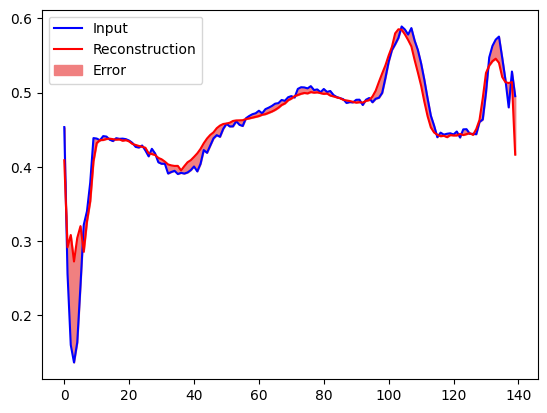

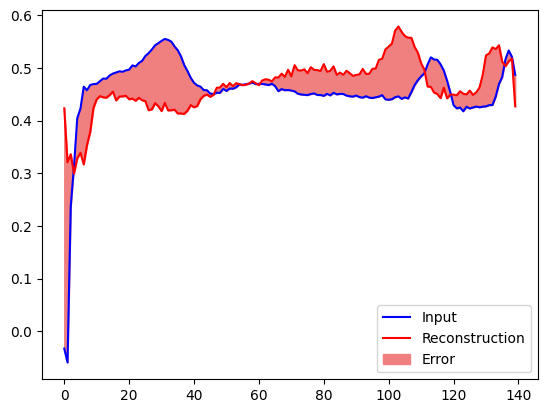

In [99]:
#Lets see some more result visually !!
plot(normal_test_data, 0)
plot(normal_test_data, 1)
plot(normal_test_data, 3)

In [ ]:
# import tensorflow as tf
# from tensorflow.keras import Model, layers

# class AnomalyDetector(Model):
#     def __init__(self):
#         super(AnomalyDetector, self).__init__()
#         self.encoder = tf.keras.Sequential([
#             layers.Input(shape=(140, 1)),
#             layers.Conv1D(32, 3, activation="relu", padding="same"),
#             layers.MaxPooling1D(pool_size=2, padding='same'),
#             layers.Conv1D(16, 3, activation="relu", padding="same"),
#             layers.MaxPooling1D(pool_size=2, padding='same'),
#             layers.Conv1D(8, 3, activation="relu", padding="same"),
#             layers.MaxPooling1D(pool_size=2, padding='same')
#         ])

#         self.decoder = tf.keras.Sequential([
#             layers.Conv1D(8, 3, activation="relu", padding="same"),
#             layers.UpSampling1D(size=2),
#             layers.Conv1D(16, 3, activation="relu", padding="same"),
#             layers.UpSampling1D(size=2),
#             layers.Conv1D(32, 3, activation="relu"),
#             layers.UpSampling1D(size=2),
#             layers.Conv1D(1, 3, activation="sigmoid", padding="same")
#         ])

#     def call(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded